In [1]:
%matplotlib inline


# Relative Positional Key Attention


### Compute attn contribution between relative positional keys and queries

In [2]:
# 1D relpos keys
import torch

import triton
import triton.language as tl


@triton.jit
def relpos_key_attn_kernel(
    x_ptr,             # (B, S, 1)
    output_ptr,        # (B, S, S)
    queries_ptr,       # (B, S, DIMS)
    relpos_keys_ptr,   # (2 * extent + 1, DIMS)
    dseq,              # Sequence length S
    extent,
    DIMS: tl.constexpr,   # Dimension of keys/queries
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process
):
    batch = tl.program_id(axis=0)
    row = tl.program_id(axis=1)
    colblock = tl.program_id(axis=2)

    # Load positions
    block_start = batch * dseq + colblock * BLOCK_SIZE
    x_query_ptr = x_ptr + batch * dseq + row
    x_key_offsets = block_start + tl.arange(0, BLOCK_SIZE)
    x_key_ptrs = x_ptr + x_key_offsets
    x_key_mask = colblock * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE) < dseq
    x_query = tl.load(x_query_ptr)
    x_key = tl.load(x_key_ptrs, mask=x_key_mask)
    # Compute relative positions
    relpos = x_key - x_query
    # Compute relative position key indices
    relpos_indices = tl.minimum(tl.maximum(relpos, -extent), extent) + extent
    # Load keys and queries
    relpos_keys_ptrs = relpos_keys_ptr + (DIMS * relpos_indices[:, None] + tl.arange(0, DIMS)[None, :])
    relpos_keys = tl.load(relpos_keys_ptrs)
    query_ptrs = queries_ptr + batch * dseq * DIMS + row * DIMS + tl.arange(0, DIMS)[None, :]    
    query = tl.load(query_ptrs)
    output = tl.sum(relpos_keys * query, axis=1)

    out_offsets = batch * dseq * dseq + colblock * BLOCK_SIZE + dseq * row + tl.arange(0, BLOCK_SIZE)
    out_mask = colblock * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE) < dseq
    tl.store(output_ptr + out_offsets, output, mask=out_mask)

In [3]:
# 1D relpos keys
import torch

import triton
import triton.language as tl


@triton.jit
def relpos_key_attn_bwd_dout_dkeys_kernel(
    x_ptr,                # (B, S, 1)
    dout_ptr,             # (B, S, S)
    dout_stride0, dout_stride1, dout_stride2,
    queries_ptr,          # (B, S, DIMS)
    drelpos_keys_ptr,     # (2 * extent + 1, DIMS)
    dseq,                 # Sequence length S
    extent,
    DIMS: tl.constexpr,   # Dimension of keys/queries
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process
):
    batch = tl.program_id(axis=0)
    row = tl.program_id(axis=1)
    colblock = tl.program_id(axis=2)

    # Load positions
    block_start = batch * dseq + colblock * BLOCK_SIZE
    x_query_ptr = x_ptr + batch * dseq + row
    x_key_offsets = block_start + tl.arange(0, BLOCK_SIZE)
    x_key_ptrs = x_ptr + x_key_offsets
    x_key_mask = colblock * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE) < dseq
    x_query = tl.load(x_query_ptr)
    x_key = tl.load(x_key_ptrs, mask=x_key_mask)
    # Compute relative positions
    relpos = x_key - x_query
    # Compute relative position key indices
    relpos_indices = tl.minimum(tl.maximum(relpos, -extent), extent) + extent
    # Load query
    query_ptrs = queries_ptr + batch * dseq * DIMS + row * DIMS + tl.arange(0, DIMS)[None, :]    
    query = tl.load(query_ptrs)
    # Load dout
    dout_ptrs = dout_ptr + batch * dout_stride0 + row * dout_stride1  + colblock * BLOCK_SIZE * dout_stride2 + tl.arange(0, BLOCK_SIZE)[:, None] * dout_stride2
    dout = tl.load(dout_ptrs)
    # Add query to gradient of all relpos keys
    drelpos_keys_ptrs = drelpos_keys_ptr + (DIMS * relpos_indices[:, None] + tl.arange(0, DIMS)[None, :])
    out_mask = colblock * BLOCK_SIZE * DIMS + DIMS * tl.arange(0, BLOCK_SIZE)[:, None] + tl.arange(0, DIMS)[None, :] < dseq * DIMS
    #tl.atomic_add(drelpos_keys_ptrs, dout * query, mask=out_mask)
    tl.atomic_add(drelpos_keys_ptrs, dout * query, mask=out_mask)

    #out_offsets = batch * dseq * dseq + colblock * BLOCK_SIZE + dseq * row + tl.arange(0, BLOCK_SIZE)[:, None]
    #out_mask2 = colblock * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)[:, None] < dseq
    #tl.store(output_ptr + out_offsets, dout)#, mask=out_mask2)

In [4]:

class RelposKeyAttn(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx,
        # positions
        x: torch.Tensor,
        # queries (S, dhead)
        queries: torch.Tensor,
        # relative positional keys embedding (2 * extent + 1, dhead)
        relpos_keys: torch.Tensor,
        # extent
        extent
    ):
        batch, elements, feats = x.shape
        nembed, dhead = relpos_keys.shape
        _batch, _elements, _dhead = queries.shape
        assert feats == 1
        assert batch == _batch
        assert elements == _elements
        assert dhead == _dhead
        assert nembed == 2 * extent + 1
        # We need to preallocate the output
        output = torch.empty((batch, elements, elements,), device=x.device, dtype=torch.float32)
        #output = torch.full((batch, elements, elements,), 1337, dtype=torch.float32).to(x.device)
        assert x.is_cuda and output.is_cuda
        n_elements = elements
        grid = lambda meta: (batch, n_elements, triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
        relpos_key_attn_kernel[grid](
            x,
            output,
            queries,
            relpos_keys,
            n_elements,
            extent,
            DIMS=dhead,
            BLOCK_SIZE=32,
            num_warps=1,
        )
        ctx.save_for_backward(x, queries, relpos_keys)
        ctx.extent = extent
        return output
    
    @staticmethod
    def backward(ctx, dout):
        x, queries, relpos_keys = ctx.saved_tensors
        batch, n_elements, feats = x.shape
        nembed, dhead = relpos_keys.shape
        drelpos_keys = torch.zeros_like(relpos_keys, device=x.device)

        grid = lambda meta: (batch, n_elements, triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
        relpos_key_attn_bwd_dout_dkeys_kernel[grid](
            x,
            dout,
            dout.stride()[0],
            dout.stride()[1],
            dout.stride()[2],
            queries,
            drelpos_keys,
            n_elements,
            ctx.extent,
            DIMS=dhead,
            BLOCK_SIZE=32,
            num_warps=1,
        )

        return None, None, drelpos_keys, None

relpos_key_attn = RelposKeyAttn.apply

torch.manual_seed(0)

positions = torch.tensor([
    [[0], [-5], [0], [-13], [-5], [5], [100]],
    [[0], [-5], [0], [-13], [0], [5], [3]],
]).to('cuda')
#positions = torch.zeros((2, 7, 1), dtype=torch.int64).to('cuda')
queries = torch.zeros(2, 7, 4).to('cuda')
queries[:, :4] = torch.tensor([1.0, 1.0, -1.0, -1.0])
queries[:, 5:] = torch.tensor([0.0, 0.0, 2.0, 0])
relpos_keys = torch.zeros(11, 4).to('cuda')
relpos_keys[:5] = torch.tensor([-0.5, -0.5, 1.0, 0])
relpos_keys[5] = torch.tensor([1.0, 1.0, 0, 0])
relpos_keys[6:] = torch.tensor([-0.5, -0.5, 0.0, 1.0])

print(positions)

relpos_keys.requires_grad_(True)
#queries.requires_grad_(True)

output = relpos_key_attn(positions, queries, relpos_keys, 5)
print("output2", output[0])
print("output1", output[1])
(output * torch.tensor([1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0], device='cuda')).sum().backward()
print("grad", relpos_keys.grad)

tensor([[[  0],
         [ -5],
         [  0],
         [-13],
         [ -5],
         [  5],
         [100]],

        [[  0],
         [ -5],
         [  0],
         [-13],
         [  0],
         [  5],
         [  3]]], device='cuda:0')
output2 tensor([[ 2., -2.,  2., -2., -2., -2., -2.],
        [-2.,  2., -2., -2.,  2., -2., -2.],
        [ 2., -2.,  2., -2., -2., -2., -2.],
        [-2., -2., -2.,  2., -2., -2., -2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  2.,  2.,  2.,  2.,  0.,  0.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  0.]], device='cuda:0',
       grad_fn=<SelectBackward0>)
output1 tensor([[ 2., -2.,  2., -2.,  2., -2., -2.],
        [-2.,  2., -2., -2., -2., -2., -2.],
        [ 2., -2.,  2., -2.,  2., -2., -2.],
        [-2., -2., -2.,  2., -2., -2., -2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  2.,  2.,  2.,  2.,  0.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  0.,  0.]], device='cuda:0',
       grad_fn=<SelectBackward0>)
grad 

In [5]:
def relpos_key_attn_torch(
    # positions
    x: torch.Tensor,
    # queries (S, dhead)
    queries: torch.Tensor,
    # relative positional keys embedding (2 * extent + 1, dhead)
    relpos_keys: torch.Tensor,
    # extent
    extent
):
    extent = torch.tensor(extent).to(x.device)
    dbatch, elements, feats = x.shape
    nembed, dhead = relpos_keys.shape
    assert feats == 1
    assert nembed == 2 * extent + 1
    assert queries.size(-1) == dhead

    # Batch x Seq x Seq x Pos relative positions
    relative_positions = x.squeeze(-1).unsqueeze(1) - x.unsqueeze(2).squeeze(-1)

    clamped_positions = torch.max(
        torch.min(
            extent,  # type: ignore
            relative_positions.long(),
        ),
        -extent,  # type: ignore
    )
    positive_positions = clamped_positions + extent
    indices = positive_positions#(positive_positions * self.strides).sum(dim=-1).long()
    # Batch x Seq x Seq x d_model
    relkeys = relpos_keys[indices]
    return torch.einsum("bsd,bstd->bst", queries, relkeys)

In [6]:
dhead = 128
size = 80
dbatch = 64
x = (torch.rand((dbatch, size, 1), device='cuda', dtype=torch.float32) * 10).long()
queries = torch.rand((dbatch, size, dhead), device='cuda', dtype=torch.float32)
embeddings = torch.rand((2 * 5 + 1, dhead), device='cuda', dtype=torch.float32)
embeddings_torch = embeddings.clone()
embeddings.requires_grad_(True)
embeddings_torch.requires_grad_(True)

output_triton = relpos_key_attn(x, queries, embeddings, 5)
output_torch = relpos_key_attn_torch(x, queries, embeddings_torch, 5)
print(output_torch[1])
print(output_triton[1])
print(
    f'The maximum difference between torch and triton is '
    f'{torch.max(torch.abs(output_torch - output_triton))}'
)

randout = torch.rand((dbatch, size, size), device='cuda', dtype=torch.float32)
(output_triton * randout).sum().backward()
(output_torch * randout).sum().backward()
print(embeddings.grad)
print(embeddings_torch.grad)
print(
    f'The maximum relative gradient difference between torch and triton is '
    f'{1 - torch.max(torch.abs(embeddings.grad - embeddings_torch.grad) / (torch.abs(embeddings.grad - embeddings_torch.grad) + 1e-6))}'
)

tensor([[30.2208, 29.7816, 29.7816,  ..., 29.7816, 30.6755, 34.9812],
        [31.5203, 28.9670, 34.0328,  ..., 32.0844, 33.9999, 30.4027],
        [31.6798, 29.2125, 27.1991,  ..., 30.8380, 31.6798, 31.6798],
        ...,
        [34.9031, 32.8088, 34.4261,  ..., 33.1806, 34.9031, 33.1504],
        [28.7967, 30.4605, 29.9418,  ..., 29.9418, 29.7341, 29.6608],
        [31.0516, 32.2823, 33.3266,  ..., 33.7131, 31.9300, 31.7409]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[30.2208, 29.7816, 29.7816,  ..., 29.7816, 30.6755, 34.9812],
        [31.5203, 28.9670, 34.0328,  ..., 32.0844, 33.9999, 30.4027],
        [31.6798, 29.2125, 27.1991,  ..., 30.8380, 31.6798, 31.6798],
        ...,
        [34.9031, 32.8088, 34.4261,  ..., 33.1806, 34.9031, 33.1504],
        [28.7967, 30.4605, 29.9418,  ..., 29.9418, 29.7341, 29.6608],
        [31.0516, 32.2823, 33.3266,  ..., 33.7132, 31.9300, 31.7409]],
       device='cuda:0', grad_fn=<SelectBackward0>)
The maximum difference between

We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:



Seems like we're good to go!



## Benchmark
We can now benchmark our custom op on vectors of increasing sizes to get a sense of how it does relative to PyTorch.
To make things easier, Triton has a set of built-in utilities that allow us to concisely plot the performance of your custom ops
for different problem sizes.



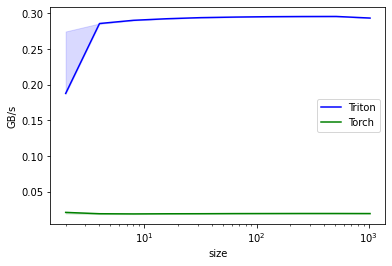

relpos-keyattn-performance:
     size    Triton     Torch
0     2.0  0.187661  0.020885
1     4.0  0.285663  0.019015
2     8.0  0.290157  0.018765
3    16.0  0.292398  0.018967
4    32.0  0.293917  0.019035
5    64.0  0.294702  0.019211
6   128.0  0.295235  0.019283
7   256.0  0.295488  0.019356
8   512.0  0.295580  0.019352
9  1024.0  0.293330  0.019271


In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # argument names to use as an x-axis for the plot
        x_vals=[
            2 ** i for i in range(1, 11, 1)
        ],  # different possible values for `x_name`
        x_log=True,  # x axis is logarithmic
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg`
        #line_vals=['triton'],#, 'torch'],  # possible values for `line_arg`
        line_names=['Triton', 'Torch'],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel='GB/s',  # label name for the y-axis
        plot_name='relpos-keyattn-performance',  # name for the plot. Used also as a file name for saving the plot.
        args={'mode': 'backward'},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(size, provider, mode='backward'):
    dhead = 128
    dseq = 50
    x = (torch.rand((size, dseq, 1), device='cuda', dtype=torch.float32)).long()
    queries = torch.rand((size, dseq, dhead), device='cuda', dtype=torch.float32)
    embeddings = torch.rand((2 * 5 + 1, dhead), device='cuda', dtype=torch.float32)
    dout = .1 * torch.rand((size, dseq, dseq), device='cuda', dtype=torch.float32)

    #y = (torch.rand(size, device='cuda', dtype=torch.float32) * 10).long()
    if provider == 'torch':
        if mode == 'backward':
            embeddings.requires_grad_(True)
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: relpos_key_attn_torch(x, queries, embeddings, 5).backward(dout, retain_graph=True))
        else:
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: relpos_key_attn_torch(x, queries, embeddings, 5))
    if provider == 'triton':
        if  mode == 'backward':
            embeddings.requires_grad_(True)
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: relpos_key_attn(x, queries, embeddings, 5).backward(dout, retain_graph=True))
        else:
            ms, min_ms, max_ms = triton.testing.do_bench(lambda: relpos_key_attn(x, queries, embeddings, 5))
    gbps = lambda ms: 4 * dhead * size * dseq / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)